In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from utils import plot_tree_boundaries

features = ['age','acutephysiologyscore']
outcome = 'actualhospitalmortality'

data = pd.read_csv('eicu_processed.csv')

x = data[features]
y = data[outcome]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=42)

# Model Evaluation

We’ve now learned the basics of the various tree methods and have visualized most of them; however, how do we actually know which one is the best predictive model? Let’s finish by comparing the performance of our models on our held-out test data. Our goal, remember, is to predict whether or not a patient will survive their hospital stay using the patient’s age and acute physiology score computed on the first day of their ICU stay.

We will begin by training a model for each of the techniques we have looked at so far.

In [37]:
# Fill missing data with -1
data_no_nans = data.fillna(-1)

x = data_no_nans[features]
y = data_no_nans[outcome]

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.7, random_state =  42)

In [38]:
from sklearn import metrics, ensemble, tree

models = dict()
models['Decision Tree'] = tree.DecisionTreeClassifier(criterion='entropy', splitter='best').fit(x_train, y_train)
models['Gradient Boosting'] = ensemble.GradientBoostingClassifier(n_estimators=10).fit(x_train, y_train)
models['Random Forest'] = ensemble.RandomForestClassifier(n_estimators=10).fit(x_train, y_train)
models['Bagging'] =  ensemble.BaggingClassifier(n_estimators=10).fit(x_train, y_train)
models['AdaBoost'] =  ensemble.AdaBoostClassifier(n_estimators=10).fit(x_train, y_train)

We now have a model for each of the techniques we have looked at. There are a number of different metrics we can use to measure the performance of our model, depending on what we want to measure. The most basic is accuracy - on the test set, how many predictions does our model get correct?

In [39]:
print('Accuracy\tModel')
for current_model in models:    
    predicted_proba = models[current_model].predict_proba(x_test)[:, 1]
    predictions = models[current_model].predict(x_test)
    
    score = metrics.accuracy_score(y_test, predictions)
    print('{:0.3f}\t{}'.format(score, current_model))

Accuracy	Model
0.882	Decision Tree
0.938	Gradient Boosting
0.907	Random Forest
0.882	Bagging
0.932	AdaBoost


As you might expect (but is, crucially, not always the case!), the more advanced gradient boosting technique achieves the best performance.

**Question:** What is a possible issue with relying on accuracy as a performance metric?

Accuacy is not always a suitable performance metric, especially when our data is unbalanced (i.e. there are many more samples in one class than the other).

Another issue with accuracy is that it only measures performance at a single decision threshold. To inspect how well our models perform at different thresholds, we can plot the Receiver Operating Characteristic curve. This curve plots the false positive rate (x-axis) against the true positive rate (y-axis) at different decision thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives (and vice-versa when increasing the threshold). We can summarise this curve by calculating the area under the curve (AUROC, for Area Under the Receiver Operating Characteristic curve).

**Task:** Search for the correct functions in [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) to display the ROC curve, and calculate the AUROC for each model.

roc_auc_score for str: 0.70
roc_auc_score for str: 0.89
roc_auc_score for str: 0.76
roc_auc_score for str: 0.80
roc_auc_score for str: 0.89


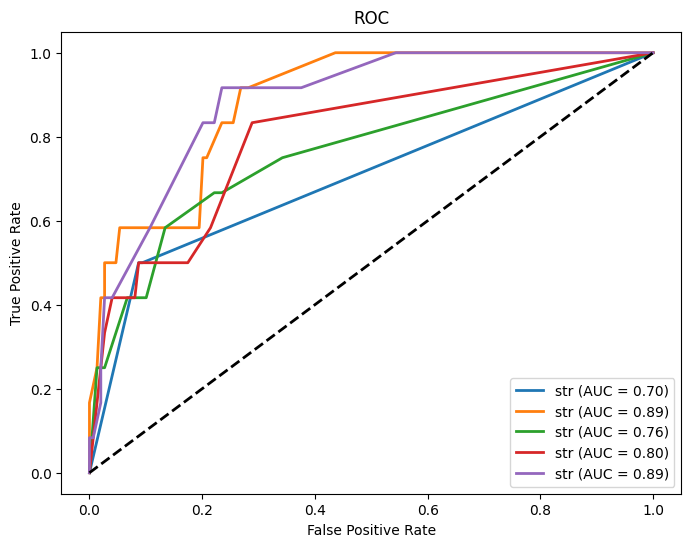

In [40]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
from sklearn.preprocessing import label_binarize   
 
plt.figure(figsize=(8, 6))  
for idx, current_model in enumerate(models):  
    ax = plt.subplot()

    y_score = models[current_model].predict_proba(x_test)[:, 1]  
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_score)   
    roc_auc = roc_auc_score(y_test, y_score)  
    print(f'roc_auc_score for {current_model.__class__.__name__}: {roc_auc:.2f}')  
    plt.plot(false_positive_rate, true_positive_rate, lw=2,  
             label=f'{current_model.__class__.__name__} (AUC = {roc_auc:.2f})')  
   
plt.plot([0, 1], [0, 1], 'k--', lw=2)  
  
plt.title('ROC')  
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate')  

plt.legend(loc="lower right")  
plt.show()
    
# print('AUROC\tModel')
# for current_model in models:    
#     # Calculate and print AUROC

## Precision and Recall

A binary classification model can fail in one of two ways: false negatives (a predictive model misses a positive sample) and false positives (a predictive model incorrectly labels a negative sample as positive). In some cases, we may prefer our model to make one type of error over the other. For example, in our mortality prediction scenario, it may be desireable to make fewer false negative classifications (as this means we will miss patients at risk of critical deterioration) at the expense of making more false positive errors. Conversely, when doing email spam detection, you likely want to prioritize minimizing false positives (even if that results in a significant increase of false negatives).

This is where metrics such as precision and recall come in. Precision measures: What proportion of positive identifications was actually correct?

**Question:** Can you come up with a possible formula for precision?

Recall, on the other hand, measures proportion of actual positives was identified correctly?

**Question:** Can you come up with a possible formula for recall?

Let's calculate the precision and recall of our models.

**Task:** Search for the correct functions in [sklearn.metrics](https://scikit-learn.org/stable/modules/model_evaluation.html) to calculate the precision and recall for each model.

In [41]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print('Precision\tRecall\tModel')
for current_model in models:    
    # Calculate and print the precision and recall
    y_predict = models[current_model].predict(x_test)
    precision = precision_score(y_predict, y_test)
    recall = recall_score(y_predict, y_test)
    print('{}\t{}\t{}'.format(precision, recall, current_model))
    

Precision	Recall	Model
0.5	0.3157894736842105	Decision Tree
0.4166666666666667	0.625	Gradient Boosting
0.3333333333333333	0.36363636363636365	Random Forest
0.4166666666666667	0.29411764705882354	Bagging
0.4166666666666667	0.5555555555555556	AdaBoost


We can see that all of our models have low precision and recall scores, despite having high AUROC and accuracy. Let's take a look at the Gradient Boosting results in a bit more detail to see what these results are telling us.

**Question:** The gradient boosting model has a precision of 0.6667 - what does this mean in terms of the positively classified predictions?

**Question:** The gradient boosting model has a recall of 0.333 - what does this mean in terms of our predictions?

As our model has a precision of 0.6667, this means that when it predicts a patient will not survive their hospital stay, it is correct two thirds of the time. With a recall of 0.3333, it means we correctly 33% of patients who do not survive their stay.

Precision and recall are opposing metrics - by increasing the decision threshold we will increase precision while reducing recall, and vice-versa. We can visualise this by plotting a precision recall curve.

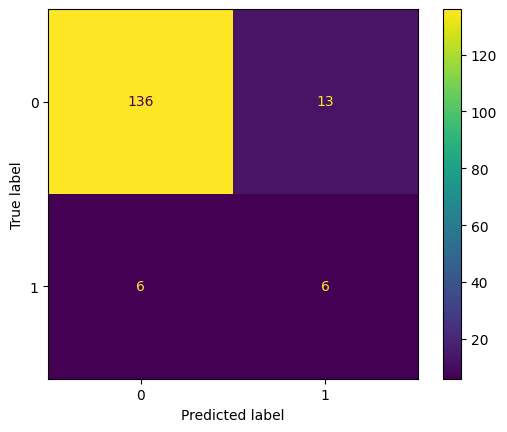

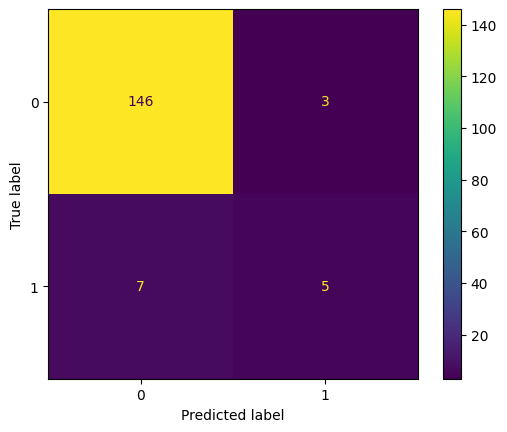

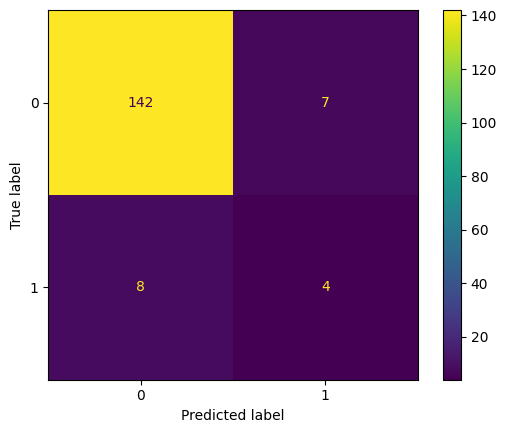

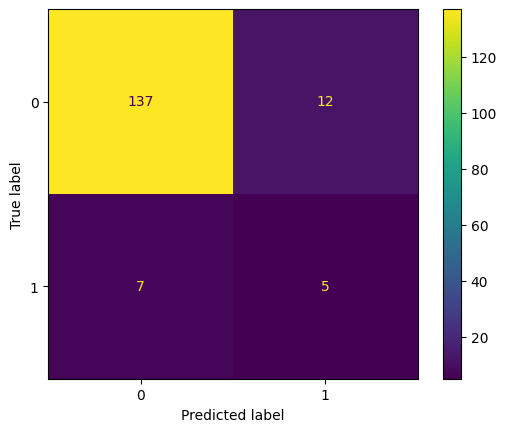

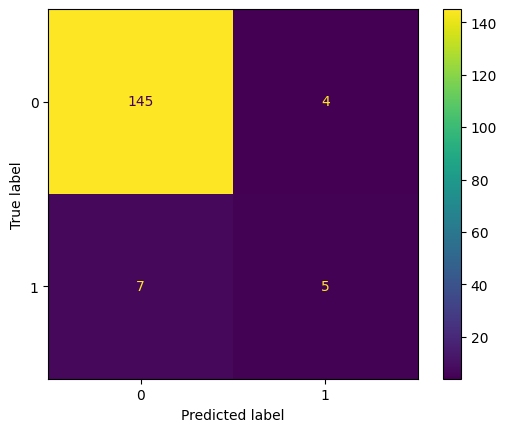

In [42]:
from sklearn.metrics import ConfusionMatrixDisplay

for current_model in models:    
    # Show the precision-recall curve
    ConfusionMatrixDisplay.from_estimator(models[current_model], x_test, y_test)

The F-score measures this trade-off between precision and recall, and is often used to give a general idea of model performance - especially when the data is imbalanced. Typically we use the F1 score, which is the harmonic mean of precision and recall, but this can be changed to the F-β score, which weights precision by β.

**Question:** What is the formula for the F-β score?

Let's calculate the F1 score of our models.

In [52]:
from sklearn.metrics import f1_score

print('F1\tModel')
for current_model in models:    
    # Calculate the F1 score for the model
    y_pre = models[current_model].predict(x_test)
    f1_score_1 = f1_score(y_test, y_pre)
    print('{}\t{}'.format(f1_score_1, current_model))

F1	Model
0.3870967741935484	Decision Tree
0.5	Gradient Boosting
0.34782608695652173	Random Forest
0.3448275862068966	Bagging
0.4761904761904762	AdaBoost


With such low precision and recall values, our models may not be very useful in practice. There are multiple possible explanations for this: our task might be difficult, our models might not be powerful enough and so on. One notable point is that our data is imbalanced, and we have (so far) only used two features (age and acute physiology score) in our models.

**Question:** What proportion of our data is classified as a positive class (i.e. how many patients do not survive their hospital stay)?

In the next (and final) workbook, we will look at using different Python libraries to create more complex models that incorporate all available features in the dataset.